# An Evaluation of Combining Classification Methods for CIFAR-10

## Helpful Resources

For general working with CIFAR-10 and pytorch: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

## Imports

If you need imports put them here

In [ ]:
from torch import nn, optim
import torch
import torchvision
import torchvision.transforms as transforms

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import six

from itertools import islice

#from st_moe_pytorch import MoE

## Downloading the Dataset

Assigned to: Omar

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
X_tr = train_set.data
y_tr = np.array(train_set.targets)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)
X_te = test_set.data
y_te = np.array(test_set.targets)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Dataset Exploration

Assigned to: Omar

<hr>

Get shape and unique values

In [ ]:
print('Shape of train data (data and labels):', X_tr.shape, y_tr.shape)
print('Shape of test data (data and labels):', X_te.shape, y_te.shape)
np.unique(X_tr)

Shape of train data (data and labels): (50000, 32, 32, 3) (50000,)
Shape of test data (data and labels): (10000, 32, 32, 3) (10000,)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Normally I'm used to black and white images, but X actually has a 4th dimension for RGB images (it's of size 3)

[59 62 63]


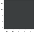

In [ ]:
print(X_tr[0][0][0])
plt.imshow([[X_tr[0][0][0]]])
# set plot to smaller size (to emulate a pixel)
plt.gcf().set_dpi(8)
# https://www.color-hex.com/color/3b3e3f

Plotting the summary statistics for each category in the training data:

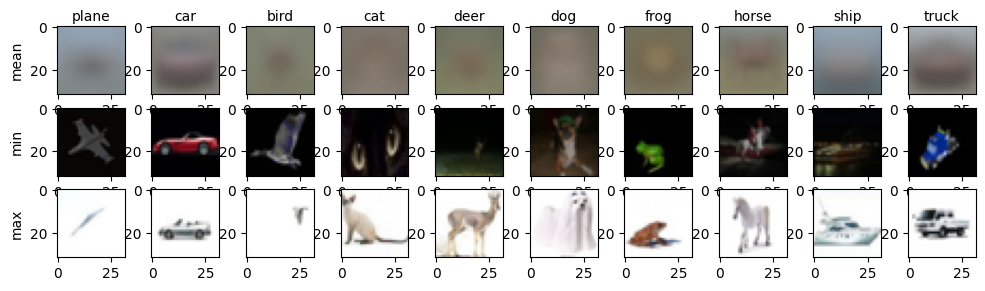

In [ ]:
def get_min_max(images: np.ndarray) -> np.ndarray:
    # sum of all rgb rows and columns
    sums = np.sum(images, axis=(1, 2, 3))  # Sum across height and width

    # get min and max indices
    min_sum_index = np.argmin(sums)
    max_sum_index = np.argmax(sums)

    # get min and max image from indices
    return images[min_sum_index], images[max_sum_index]

figure, axes = plt.subplots(3, 10, figsize=(12, 3))
# set bottom label
axes[0][0].set_ylabel('mean')
axes[1][0].set_ylabel('min')
axes[2][0].set_ylabel('max')

for i in range(10):
    # get all X belonging to category i
    index_c = np.where(y_tr == i)
    X_c = X_tr[index_c]
    # set top label
    axes[0][i].xaxis.set_label_position('top')
    axes[0][i].set_xlabel(classes[i])
    # show images
    axes[0][i].imshow(np.int64(np.mean(X_c, axis=0)))
    min_img, max_img = get_min_max(X_c)
    axes[1][i].imshow(min_img)
    axes[2][i].imshow(max_img)

Projecting the training data into a 2D latent representation for visualization

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.012s...
[t-SNE] Computed neighbors for 5000 samples in 10.889s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 777.253682
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.357513
[t-SNE] KL divergence after 10

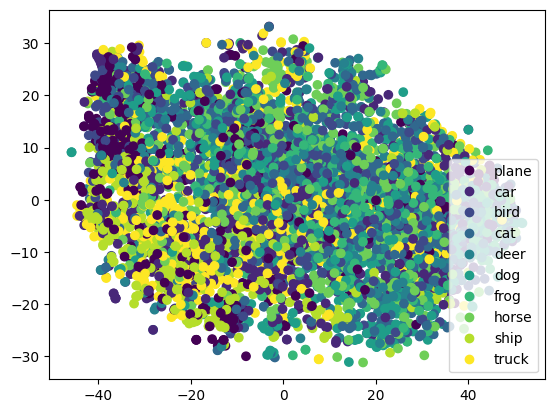

In [ ]:
random_indices = np.random.choice(X_tr.shape[0], size=5000, replace=False)
X_rand_sample = X_tr[random_indices]
y_rand_sample = y_tr[random_indices]

X_2d = TSNE(verbose=1).fit_transform(X_rand_sample.reshape(X_rand_sample.shape[0], 32*32*3))

# plot X
def scatter_color(data_2d, data_y, axis=plt):
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=data_y)
    handles, _ = scatter.legend_elements()
    plt.legend(handles, classes, loc='lower right')

scatter_color(X_2d, y_rand_sample)

## Preprocessing and Partitioning Data

Assigned to: Danica

In [ ]:
# Shuffles Test Data
indices = np.arange(len(test_set))
np.random.shuffle(indices)
X_te = X_te[indices]
y_te = y_te[indices]
test_set = Subset(test_set, indices)
X_te = np.array(X_te)
y_te = np.array(y_te)
print(y_te)

[5 6 6 ... 9 9 0]


In [ ]:
train_set_mean = np.mean(X_tr/255.0, axis=(0,1,2))
train_set_std = np.std(X_tr/255.0, axis=(0,1,2))

test_set_mean = np.mean(X_te/255.0, axis=(0,1,2))
test_set_std = np.std(X_te/255.0, axis=(0,1,2))

# Define the transformation for normalization for the training set and test set
# Divide by 255 to scale pixel values to [0, 1] range (ToTensor)
# Then, apply normalization with mean and std
trainset_transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=train_set_mean,  
                         std=train_set_std)
])

testset_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=test_set_mean,  
                         std=test_set_std)
])

# Apply the transformation to the dataset
train_set.transform = trainset_transform
test_set.transform = testset_transform

# Splits data into training and validation sets
train_size = int(0.60 * len(train_set))  # 60% for training
val_size = len(train_set) - train_size  # 40% for validation
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

# Create a DataLoader to load the dataset with normalization
# You can specify batch size and other parameters as needed
#dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
X_tr_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
X_val_loader = DataLoader(val_dataset, batch_size=64)
X_te_loader = DataLoader(test_set, batch_size=64)

## Training Models

### Common Code

Copied from Rish:

In [ ]:
# Training function
def train_model(net, train_loader, val_loader, criterion, optimizer, num_epochs=25, conv=False):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(0,num_epochs):
        net.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            if conv:
                outputs = net(inputs.reshape(inputs.size(0), 3, 32, 32))
            else:
                outputs = net(inputs.view(-1, 32*32*3))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        val_loss, val_acc = evaluate_model(net, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Evaluation function
def evaluate_model(net, data_loader, criterion, conv=False):
    net.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = net(inputs.view(-1, 32*32*3))
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    loss = running_loss / total
    acc = running_corrects.double() / total
    return loss, acc

def plot_model_performance(model_name, train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    figure, axes = plt.subplots(1, 2) 
    axes[0].plot(train_loss_history)
    axes[0].plot(val_loss_history)
    axes[1].plot(train_acc_history)
    axes[1].plot(val_acc_history)
    axes[0].set_xlabel("Epochs")
    axes[1].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")
    axes[0].set_title(f'{model_name} Loss')
    axes[1].set_title(f'{model_name} Accuracy')
    axes[0].legend(["train loss", "validation loss"])
    axes[1].legend(["train accuracy", "validation accuracy"])
    axes[1].set_ylim(top=1)
    plt.subplots_adjust(wspace=0.5)

### Training and Evaluating kNN Classifier

https://www.axelmendoza.com/posts/knn-from-scratch-pytorch/

Assigned to: Danica

Create the model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.inspection import DecisionBoundaryDisplay

# Converts a specified amount of data from dataloaders into numpy arrays
def get_data(dataloader, batches):
    return_data = []
    return_labels = []
    for image, labels in islice(dataloader, 0, batches):
        images = image.view(image.size(0), -1).numpy()
        return_data.extend(images)
        return_labels.extend(labels.numpy())

    return np.array(return_data), np.array(return_labels)

# Train and fit a knn model
def train_knn(train_loader, batches, k_neighbors):
    knn = KNeighborsClassifier(n_neighbors=k_neighbors)

    X_tr_data, y_tr_data = get_data(train_loader, batches)
    knn.fit(X_tr_data, y_tr_data)

    return knn

# Return knn predictions based off a fitted model
def predict_knn(knn, dataloader):
    y_preds = []

    for inputs, labels in dataloader:
        y_preds.extend(knn.predict(inputs.view(inputs.size(0), -1).numpy().tolist()))

    return y_preds

test_knn = train_knn(X_tr_loader, 5, 5)

Evaluate the model

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


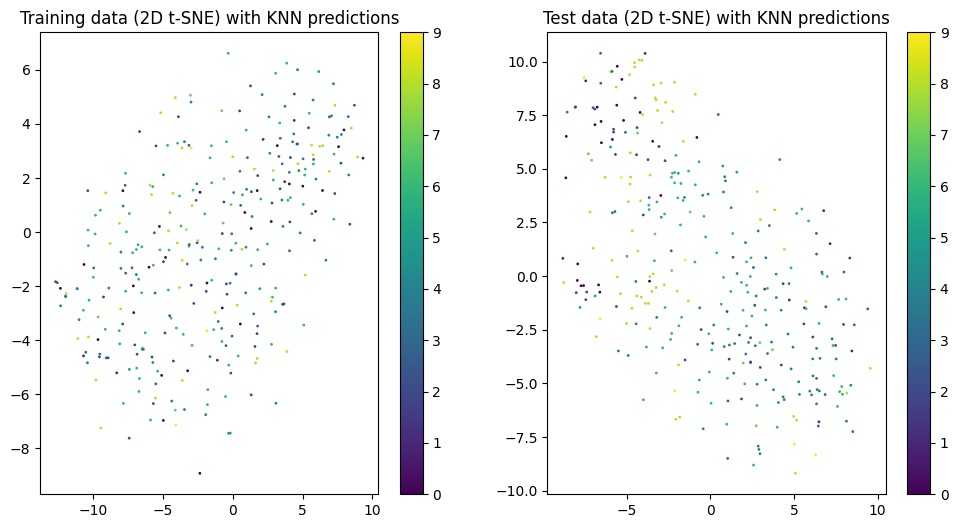

K-value: 1, Train accuracy: 0.0875, Test accuracy: 0.18125
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


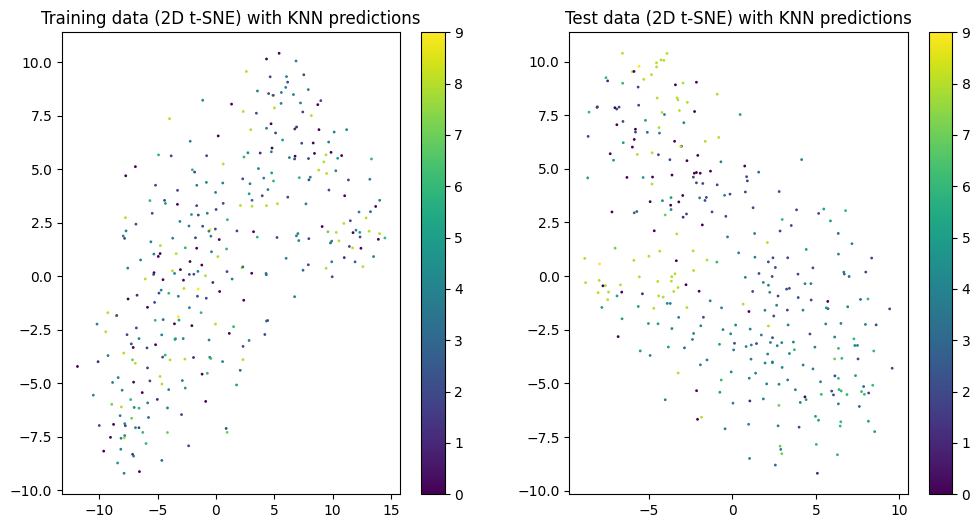

K-value: 5, Train accuracy: 0.09375, Test accuracy: 0.21875
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


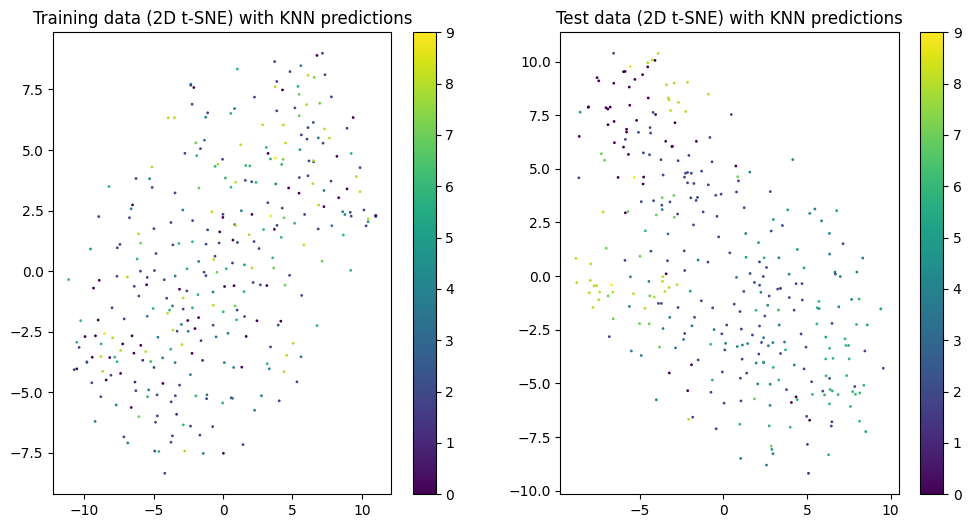

K-value: 15, Train accuracy: 0.13125, Test accuracy: 0.240625
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


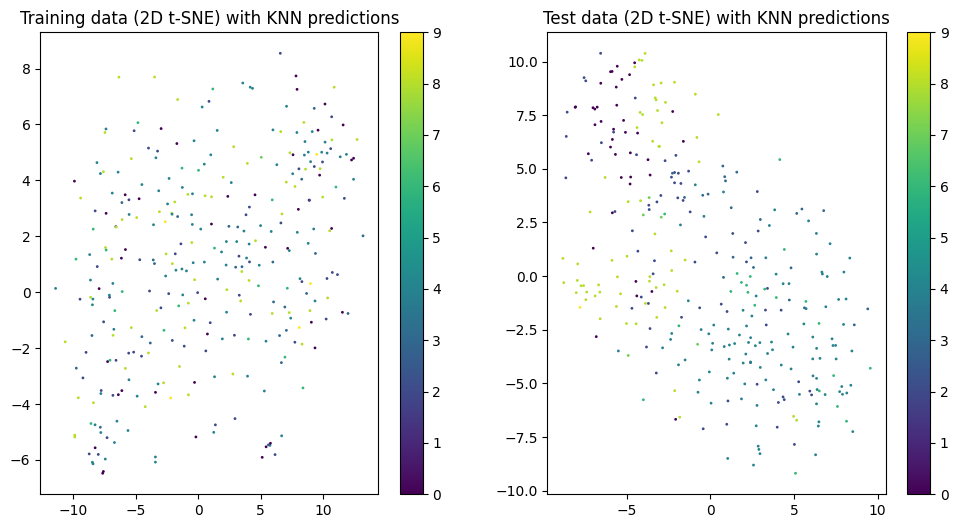

K-value: 49, Train accuracy: 0.109375, Test accuracy: 0.228125


In [ ]:
# Returns the accuracy scores of the KNN model; use get_knn_data to pass in the datapoints
def evaluate_knn(y_tr_data, y_te_data, y_pred_tr, y_pred_te):
    train_accuracy = accuracy_score(y_tr_data, y_pred_tr)
    test_accuracy = accuracy_score(y_te_data, y_pred_te)

    return train_accuracy, test_accuracy


def plot_knn(k, knn, x_train, x_test, y_pred_train, y_pred_test):
    tsne = TSNE(n_components=2, random_state=0)
    x_train_tsne = tsne.fit_transform(x_train)
    x_test_tsne = tsne.fit_transform(x_test)

    # # Create a mesh grid and predict for each point
    # x_min, x_max = x_train_tsne[:, 0].min() - 1, x_train_tsne[:, 0].max() + 1
    # y_min, y_max = x_train_tsne[:, 1].min() - 1, x_train_tsne[:, 1].max() + 1
    # xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # grid_points = np.c_[xx.ravel(), yy.ravel()]
    # Z = knn.predict(grid_points)
    # Z = Z.reshape(xx.shape)
    
    # Plot on the graphs
    plt.figure(figsize=(12, 6))

    # Plot the training data
    plt.subplot(1, 2, 1)
    #plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_pred_train, cmap='viridis', s=1)
    plt.title(f'Training data (2D t-SNE) with k = {k}')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    #plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], c=y_pred_test, cmap='viridis', s=1)
    plt.title(f'Test data (2D t-SNE) with k = {k}')
    plt.colorbar()

    # Show decision boundaries
    #display = DecisionBoundaryDisplay(xx0=X_train, y_pred_train)

    plt.show()


# Test on a certain number of batches for varying values of k
k_neighbors = [1, 5, 15, 49]
def knn(train_loader, test_loader, batches, knns):
    for k in knns:
        X_tr_data, y_tr_data = get_data(train_loader, batches)
        X_te_data, y_te_data = get_data(test_loader, batches)

        knn = train_knn(train_loader, batches, k)
        y_pred_tr = predict_knn(knn, train_loader)
        y_pred_te = predict_knn(knn, test_loader)

        accuracy_scores = evaluate_knn(y_tr_data, y_te_data, y_pred_tr[:len(y_tr_data)], y_pred_te[:len(y_te_data)])
        plot_knn(k, knn, X_tr_data, X_te_data, y_pred_tr[:len(y_tr_data)], y_pred_te[:len(y_te_data)])
        print(f"K-value: {k}, Train accuracy: {accuracy_scores[0]}, Test accuracy: {accuracy_scores[1]}")
    

knn(X_tr_loader, X_val_loader, 5, k_neighbors)

### Training and Evaluating Logistic Classifier

https://machinelearningmastery.com/building-a-logistic-regression-classifier-in-pytorch/

Assigned to: Omar

Create the model

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(32*32*3, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        return self.softmax(self.linear(x))

logreg = LogisticRegressionModel()

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(logreg.parameters(), lr=0.001)

Train the model

In [ ]:
num_epochs = 25
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(logreg, X_tr_loader, X_val_loader, criterion, optimizer, num_epochs)

Epoch 1/25, Train Loss: 2.1999, Train Acc: 0.2756, Val Loss: 2.1873, Val Acc: 0.2871
Epoch 2/25, Train Loss: 2.1757, Train Acc: 0.3018, Val Loss: 2.1675, Val Acc: 0.3085
Epoch 3/25, Train Loss: 2.1586, Train Acc: 0.3197, Val Loss: 2.1529, Val Acc: 0.3244
Epoch 4/25, Train Loss: 2.1458, Train Acc: 0.3335, Val Loss: 2.1426, Val Acc: 0.3359
Epoch 5/25, Train Loss: 2.1365, Train Acc: 0.3421, Val Loss: 2.1351, Val Acc: 0.3422
Epoch 6/25, Train Loss: 2.1292, Train Acc: 0.3487, Val Loss: 2.1294, Val Acc: 0.3470
Epoch 7/25, Train Loss: 2.1230, Train Acc: 0.3556, Val Loss: 2.1248, Val Acc: 0.3495
Epoch 8/25, Train Loss: 2.1182, Train Acc: 0.3604, Val Loss: 2.1208, Val Acc: 0.3535
Epoch 9/25, Train Loss: 2.1139, Train Acc: 0.3633, Val Loss: 2.1173, Val Acc: 0.3567
Epoch 10/25, Train Loss: 2.1101, Train Acc: 0.3671, Val Loss: 2.1144, Val Acc: 0.3593
Epoch 11/25, Train Loss: 2.1067, Train Acc: 0.3701, Val Loss: 2.1118, Val Acc: 0.3617
Epoch 12/25, Train Loss: 2.1037, Train Acc: 0.3724, Val Loss: 2

Save the Model

In [ ]:
torch.save(logreg.state_dict(), "logreg.pt")

Evaluating the Logistic Regression Model

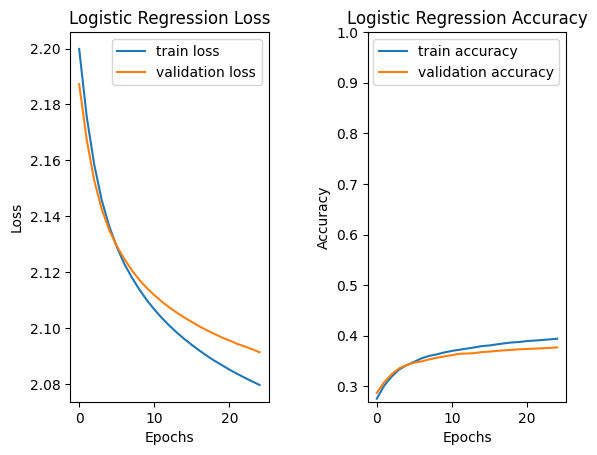

In [ ]:
plot_model_performance("Logistic Regression", train_loss_history, val_loss_history, train_acc_history, val_acc_history)

### Training and Evaluating Convolutional Neural Networks

Helpful link: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

Assigned to: Rish

Create the model CNN

In [ ]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Set up training loop

In [ ]:
cnn = CIFAR10CNN()

# Training settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Train the model
num_epochs = 25
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(cnn, X_tr_loader, X_val_loader, criterion, optimizer, num_epochs, conv=True)
'''Rewrite model training with correct vaiable names of the X and y training dataset partitions.'''

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 3072]

Save the model

In [ ]:
torch.save(cnn.state_dict(), "cnn.pt")

Evaluate the model 

In [ ]:
test_loss, test_acc = evaluate_model(cnn, X_te_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

plot_model_performance("Convolutional Neural Network",train_loss_history, val_loss_history, train_acc_history, val_acc_history )
#Works with about 75% accuracy now

NameError: name 'evaluate_model' is not defined

### Training and Fully Connected Neural Networks

See Helpful Resources at the top

Assigned to: Rish

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)  # CIFAR-10 has 10 classes
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)  # No activation function on the last layer
        return x

net = FCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(net.parameters(), lr=0.001)  # You can choose different optimizers and learning rates


In [ ]:
num_epochs = 25
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    net, X_tr_loader, X_val_loader, criterion, optimizer, num_epochs=num_epochs
)


Epoch 1/25, Train Loss: 1.7634, Train Acc: 0.3683, Val Loss: 1.6517, Val Acc: 0.4163
Epoch 2/25, Train Loss: 1.5546, Train Acc: 0.4451, Val Loss: 1.5713, Val Acc: 0.4460
Epoch 3/25, Train Loss: 1.4318, Train Acc: 0.4937, Val Loss: 1.5069, Val Acc: 0.4702
Epoch 4/25, Train Loss: 1.3357, Train Acc: 0.5253, Val Loss: 1.4854, Val Acc: 0.4950
Epoch 5/25, Train Loss: 1.2422, Train Acc: 0.5597, Val Loss: 1.4627, Val Acc: 0.4960
Epoch 6/25, Train Loss: 1.1543, Train Acc: 0.5901, Val Loss: 1.4959, Val Acc: 0.4978
Epoch 7/25, Train Loss: 1.0750, Train Acc: 0.6194, Val Loss: 1.4659, Val Acc: 0.5104
Epoch 8/25, Train Loss: 0.9940, Train Acc: 0.6448, Val Loss: 1.5296, Val Acc: 0.5067
Epoch 9/25, Train Loss: 0.9225, Train Acc: 0.6698, Val Loss: 1.5807, Val Acc: 0.5144
Epoch 10/25, Train Loss: 0.8447, Train Acc: 0.6995, Val Loss: 1.6724, Val Acc: 0.5021
Epoch 11/25, Train Loss: 0.7819, Train Acc: 0.7228, Val Loss: 1.6374, Val Acc: 0.5114
Epoch 12/25, Train Loss: 0.7220, Train Acc: 0.7416, Val Loss: 1

In [ ]:
# Save the trained model
torch.save(net.state_dict(), "fcnn.pt")


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = evaluate_model(net, X_te_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
plot_model_performance("Fully Connected Neural Network", train_loss_history, val_loss_history, train_acc_history, val_acc_history)


Test Loss: 2.7649, Test Acc: 0.5043


NameError: name 'plot_model_performance' is not defined

### Loading Models

In [ ]:
logreg = LogisticRegressionModel()
logreg.load_state_dict(torch.load('logreg.pt'))
fnn = FCNN()
fnn.load_state_dict(torch.load('fcnn.pt'))
cnn = CIFAR10CNN()
cnn.load_state_dict(torch.load('cnn.pt'))

<All keys matched successfully>

### Evaluating an Ensemble Model

For each prediction, just take the majority vote out of all 3 models we've trained.

Assigned to: Rish or Danica

Define the model

In [ ]:
from collections import Counter
import random

def get_predictions(model, data_loader, model_type):
    model.eval()
    predictions = []
    true_predictions = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            try:
                if model_type in ['logreg', 'fnn']:
                    # Flatten the input tensor
                    inputs = inputs.view(inputs.size(0), -1)  # [batch_size, num_features]

                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                true_predictions.extend(labels)
            except Exception as e:
                print("Exception occurred:", e)
    return predictions

def get_most_common_class(classes):
    most_common_classes = Counter(classes).most_common()
    max_count = most_common_classes[0][1]

    # Return most common class, in the event of a tie return a random class
    top_classes = [cl for cl, cnt in most_common_classes if cnt == max_count]
    if len(top_classes) == 1:
        return top_classes[0]
    else:
        return random.choice(top_classes)

# Returns the predictions of the ensemble
def predict_ensemble(dataloader, preds=None):
    # Generate predictions for each model
    if not preds:
        logreg_preds = get_predictions(logreg, dataloader, model_type='logreg')
        fnn_preds = get_predictions(fnn, dataloader, model_type='fnn')
        cnn_preds = get_predictions(cnn, dataloader, model_type='cnn')
    else:
        logreg_preds = preds[0]
        fnn_preds = preds[1]
        cnn_preds = preds[2]

    # Take the majority vote out of the three classifiers
    ensemble_preds = [get_most_common_class( (lr_pred, fnn_pred, cnn_pred) ) 
                        for lr_pred, fnn_pred, cnn_pred in 
                        zip(logreg_preds, fnn_preds, cnn_preds)]

    return ensemble_preds


Evaluate the model

In [ ]:
# Get the accuracy score for the ensemble's predictions
def get_ensemble_accuracy(te_dataloader):
    ensemble_preds = predict_ensemble(te_dataloader)

    # Get true test labels
    true_preds = []
    for inputs, labels in te_dataloader:
        true_preds.extend(labels)

    acc_score = accuracy_score(true_preds, ensemble_preds)
    return acc_score

# Evaluate based off the validation data
get_ensemble_accuracy(X_val_loader)

0.78815

### Training and Evaluating a Mixture of Experts Model (Optional)

Assigned to: Omar

Uses https://github.com/lucidrains/st-moe-pytorch/tree/main

Define Mixture of Experts and relevant functions:

In [ ]:
moe = MoE(
    dim = 32*32*3,
    num_experts = 2,               # increase the experts (# parameters) of your model without increasing computation
    gating_top_n = 2,               # default to top 2 gating, but can also be more (3 was tested in the paper with a lower threshold)
    threshold_train = 0.2,          # at what threshold to accept a token to be routed to second expert and beyond - 0.2 was optimal for 2 expert routing, and apparently should be lower for 3
    threshold_eval = 0.2,
    capacity_factor_train = 1.25,   # experts have fixed capacity per batch. we need some extra capacity in case gating is not perfectly balanced.
    capacity_factor_eval = 2.,      # capacity_factor_* should be set to a value >=1
    balance_loss_coef = 1e-2,       # multiplier on the auxiliary expert balancing auxiliary loss
    router_z_loss_coef = 1e-3,      # loss weight for router z-loss
    experts=nn.ModuleList([logreg, fnn, cnn]), # presets the experts
)

In [ ]:
# Training function
def train_moe(moe, train_loader, val_loader, optimizer, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(0,num_epochs):
        net.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            n = inputs.size(0)
            optimizer.zero_grad()
            preds, total_aux_loss, balance_loss, router_z_loss = get_moe_predictions(moe, inputs, evaluate=True)
            total_aux_loss.backward()
            optimizer.step()
            running_loss += total_aux_loss.item()
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        val_loss, val_acc = evaluate_moe(moe, val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Train Acc: {epoch_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

def get_moe_predictions(moe, inputs, evaluate=False, group_size=1):
    n = inputs.size(0)
    inputs = inputs.view(-1, 32*32*3)
    return_value = moe(inputs.reshape(n // group_size, group_size, 32*32*3))
    out, total_aux_loss, balance_loss, router_z_loss = return_value
    out = out.reshape(n, 10)
    _, preds = torch.max(out, 1)
    if evaluate:
        return preds, total_aux_loss, balance_loss, router_z_loss
    return preds

def predict_moe(moe, data_loader):
    with torch.no_grad():
        preds = []
        for inputs, labels in data_loader:
            preds.extend(get_moe_predictions(moe, inputs).cpu().numpy())
    return preds

# Evaluation function
def evaluate_moe(moe, data_loader):
    running_loss = np.array([0.0, 0.0, 0.0])
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            preds, total_aux_loss, balance_loss, router_z_loss = get_moe_predictions(moe, inputs, evaluate=True)
            running_loss[0] += total_aux_loss 
            running_loss[1] += balance_loss
            running_loss[2] += router_z_loss
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    loss = running_loss / total
    acc = running_corrects.double() / total
    return loss, acc

Run / train the MoE:

In [ ]:
optimizer = optim.Adam(moe.parameters(), lr=0.001)
num_epochs = 25
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_moe(moe, X_tr_loader, X_val_loader, optimizer, num_epochs)

Epoch 1/25, Train Loss: 0.011787702010571957, Train Acc: 0.7414666666666667, Val Loss: [0.00018539 0.01799562 0.00543485], Val Acc: 0.74315
Epoch 2/25, Train Loss: 0.011400076044599215, Train Acc: 0.7427, Val Loss: [0.00017468 0.01695328 0.00514639], Val Acc: 0.7435
Epoch 3/25, Train Loss: 0.0114028361171484, Train Acc: 0.7424666666666667, Val Loss: [0.00020166 0.0195455  0.00620613], Val Acc: 0.7401
Epoch 4/25, Train Loss: 0.011398819424708684, Train Acc: 0.7411666666666666, Val Loss: [0.00017721 0.01720941 0.00512006], Val Acc: 0.74365
Epoch 5/25, Train Loss: 0.011453411787251632, Train Acc: 0.7426, Val Loss: [0.00017471 0.01696732 0.00503479], Val Acc: 0.7433
Epoch 6/25, Train Loss: 0.01153383829096953, Train Acc: 0.7422, Val Loss: [0.0001812  0.01760822 0.00512146], Val Acc: 0.74275
Epoch 7/25, Train Loss: 0.011467998746534189, Train Acc: 0.7423333333333333, Val Loss: [0.00018555 0.0180209  0.00534386], Val Acc: 0.7427
Epoch 8/25, Train Loss: 0.011505694358547529, Train Acc: 0.7422

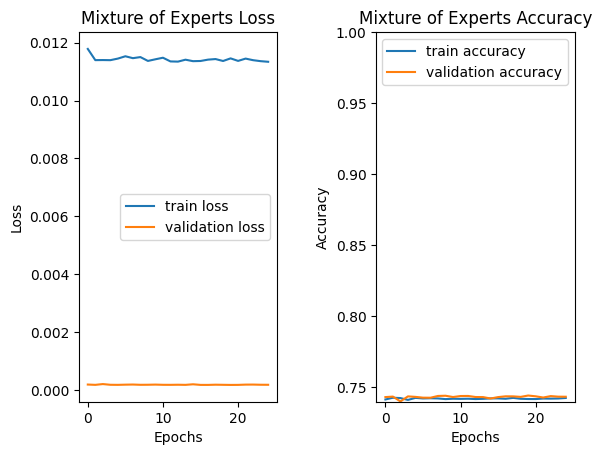

In [ ]:
plot_model_performance('Mixture of Experts', train_loss_history, list(np.array(val_loss_history)[:, 0]), train_acc_history, val_acc_history)

In [ ]:
# Save the trained model
torch.save(moe.state_dict(), "moe.pt")

Load Model

In [ ]:
moe.load_state_dict(torch.load('moe.pt'))

## Evaluating with Test Data and Visualizing Results

Table with numbers, Learning curves, Confusion matrices, Common errors, Example of errors

Might be helpful to use subplots

Assigned to: Danica, Omar

In [ ]:
def get_all_model_predictions(data_loader, normal_models, model_types, moe, knn):
    preds = []
    for model, model_type in zip(normal_models, model_types):
        preds.append(get_predictions(model, data_loader, model_type))
    preds.append(predict_ensemble(data_loader, preds))
    preds.append(predict_moe(moe, data_loader))
    preds.append(predict_knn(knn, data_loader))
    return preds

all_predictions = np.transpose(np.array(get_all_model_predictions(X_te_loader, [logreg, fnn, cnn], ['logreg', 'fnn', 'cnn'], moe, test_knn)), (1, 0))
print(all_predictions.shape)

(10000, 6)


Show Results

In [ ]:
classifiers = ['Logistic Classifier', 'FNN', 'CNN', 'Voting Ensemble', 'MoE', 'KNN']
accuracy_scores = []
for i in range(6):
    accuracy_scores.append(accuracy_score(all_predictions[:, i], y_te))
data = {
    "Accuracy Score": accuracy_scores,
}
accuracy_df = pd.DataFrame(data, index=classifiers)
accuracy_df

,Accuracy Score
Logistic Classifier,0.3694
FNN,0.4801
CNN,0.5709
Voting Ensemble,0.5356
MoE,0.4878
KNN,0.1597


Plot metrics

In [ ]:
X_2d = TSNE(verbose=1).fit_transform(X_te.reshape(X_te.shape[0], 32*32*3))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 28.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 1000

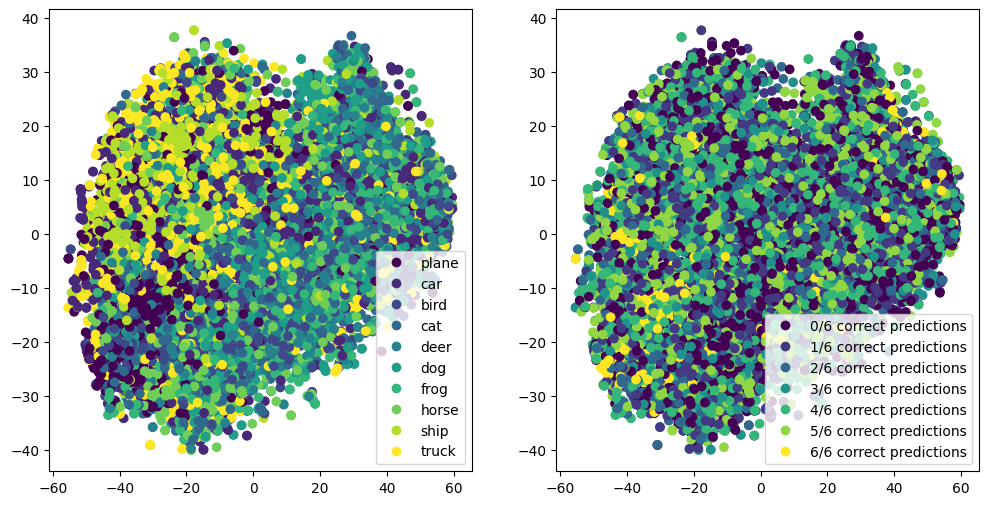

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

def scatter_color(data_2d, data_y, classes=classes, axis=plt):
    scatter = axis.scatter(data_2d[:, 0], data_2d[:, 1], c=data_y)
    handles, _ = scatter.legend_elements()
    axis.legend(handles, classes, loc='lower right')

scatter_color(X_2d, y_te, axis=axes[0])

correct_per_row = np.sum(all_predictions == y_te[:, None], axis=1)
correct_classes = ['0/6 correct predictions', '1/6 correct predictions', '2/6 correct predictions', '3/6 correct predictions', '4/6 correct predictions', '5/6 correct predictions', '6/6 correct predictions']
scatter_color(X_2d, correct_per_row, classes=correct_classes, axis=axes[1])

Get an example with 5/6 correct

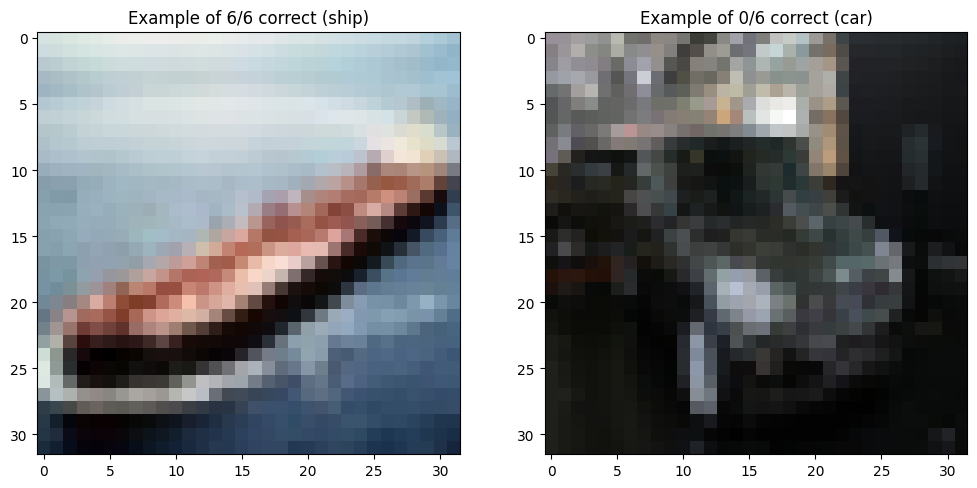

In [ ]:
good_indices = np.where(correct_per_row == 6)
bad_indices = np.where(correct_per_row == 0)
good_examples, good_labels = X_te[good_indices], y_te[good_indices]
bad_examples, bad_labels = X_te[bad_indices], y_te[bad_indices]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f"Example of 6/6 correct ({classes[good_labels[0]]})")
axes[0].imshow(good_examples[0])
axes[1].set_title(f"Example of 0/6 correct ({classes[bad_labels[0]]})")
axes[1].imshow(bad_examples[0])

confusion matrix for each classifier

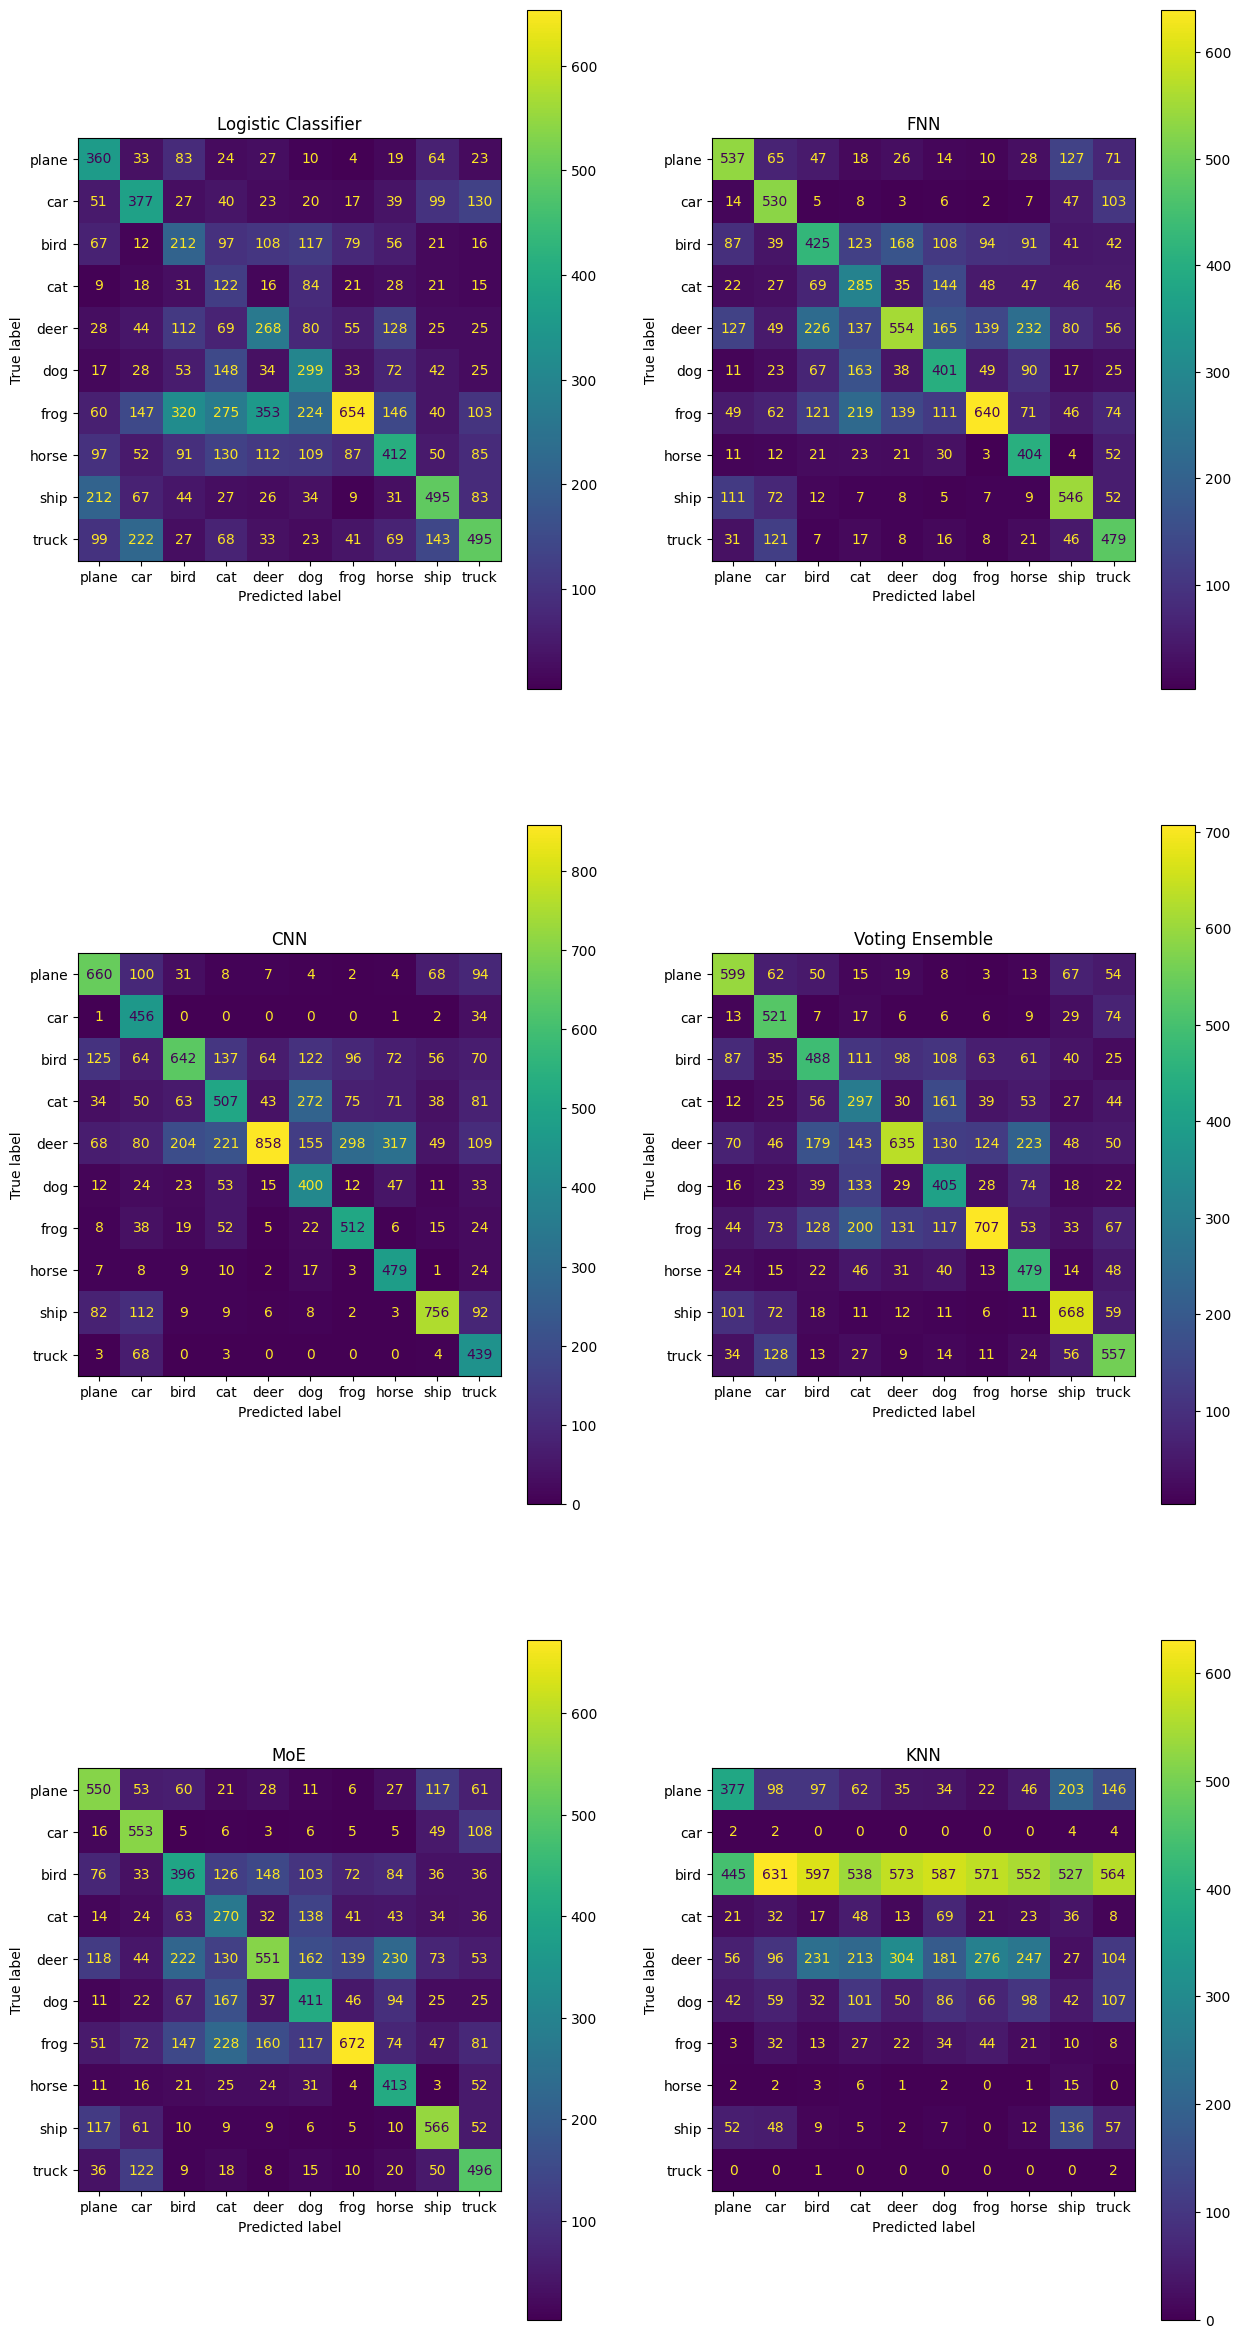

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 30))
for i in range(6):
    cm = confusion_matrix(all_predictions[:, i], y_te)
    cd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    axes[i//2][i%2].set_title(classifiers[i])
    cd.plot(ax=axes[i//2][i%2])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fbdbcbb0-c5a3-4baa-8eb2-ea5f91d251e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>